# Update Time Comparison

We compare the update time between the Apache DataSketches (ASF) HyperLogLog implementations alongside the `datasketch` HyperLogLogPlusPlus implementation.  The same hash function is used for both libraries.  We compare $4, 6, 8$ bit versions of the ASF implementations, showing that they have roughly equivalent update times which are all faster than the `datasketch` algorithm (which only provides support for $8$ bit HyperLogLog).

Experiment: for a given number $T$ trials, we fix a datasets of size $n$ for a few test input sizes $n' \le n$ and time how long it takes to update the sketch with all $n'$ items for each chosen value of $n'$.

In [1]:
import pandas as pd
import numpy as np
import datasketches as ds
import datasketch as d
import mmh3
import matplotlib.pyplot as plt
from timeit import default_timer
from typing import List
%matplotlib inline

In [2]:
class UpdateTimeProfile:

    def __init__(self, sketch_lgk:int, num_trials:int, max_log10N:int, numpy_seed:int):
        np.random.seed(numpy_seed)
        self.sketch_lgk = sketch_lgk
        self.num_trials = num_trials
        self.max_log10N = min([max_log10N, 9])
        self.max_N = 10**self.max_log10N
        self.log10_test_points = np.arange(2, self.max_log10N+1, dtype=int)

    def make_data(self) -> None:
        """
        Generates an independent dataset for each of the number of trials and converts to byte type. 
        
        NB. There is a nontrivial cost to instantiating default_timer() for each sketch.
        This makes the update time appear artificially slow for the first sketch that is tested.
        To avoid this startup cost manifesting in the measurements, we run the timer on the 
        data generation as a dummy operation.
        """
        data_start = default_timer()
        data = np.random.randint(low=0, high=1<<31-1, size=(self.max_N, self.num_trials))
        self.data_bytes = [None for _ in range(self.num_trials)]
        for trial_num, trial_data in enumerate(data.T):
            trial_all_bytes = [item.tobytes() for item in trial_data]
            self.data_bytes[trial_num] = trial_all_bytes
        data_end = default_timer()

    def _make_sketches(self, sketch_name:str) -> List[ds.hll_sketch] | List[d.HyperLogLogPlusPlus]:
        if sketch_name == "ASF8":
            return [ds.hll_sketch(self.sketch_lgk, ds.HLL_8)] * self.num_trials
        elif sketch_name == "ASF6" : 
            return [ds.hll_sketch(self.sketch_lgk, ds.HLL_6)] * self.num_trials
        elif sketch_name == "ASF4" : 
            return [ds.hll_sketch(self.sketch_lgk, ds.HLL_4)] * self.num_trials
        elif sketch_name == "datasketch":
            return [d.HyperLogLogPlusPlus(p=self.sketch_lgk, hashfunc=lambda x: mmh3.hash64(x, signed=False)[0])] * self.num_trials
        else:
            raise NotImplementedError("Only ASf, ASF6, ASF4 and datasketch methods are implemented.")

    def _run_trials_for_n(self, _n:int, sketches:List[ds.hll_sketch] | List[d.HyperLogLogPlusPlus]) -> float:
        """
        This is the function whose execution we time.
        
        _n : int --> The number of items to read from self.data_bytes, not the largest possible input
        We index into the original data to avoid expensive calls to the random number generator for 
        the data generation.
        """
        start_time = default_timer()
        for trial in range(self.num_trials):
            update_data = self.data_bytes[trial][:_n]
            sketch = sketches[trial]
            for item in update_data:
                sketch.update(item)
        end_time = default_timer()
        return (end_time - start_time)

    def run(self, sketch_name:str) -> dict:
        """
        sketch_name is a flag used to determine which sketch to test.
        It should be one of ["ASF8", "datasketch"]
        """
        results = {}
        print("\n\n")
        print("{:>10}\t{:>12}".format("Sketch", sketch_name))
        print("{:>10}\t{:>12}".format("n", "Time"))
        print("-"*26)
        for log10_N in self.log10_test_points:
            n = 10**log10_N
            sketches = self._make_sketches(sketch_name)
            cum_update_time = self._run_trials_for_n(n, sketches)
            mean_update_time = cum_update_time / (n * self.num_trials)
            print("{:>10d}\t{:>12.4e}".format(n, mean_update_time))
            results[10**log10_N] = mean_update_time
        return results

This experiment evaluates the mean update time to process $n$ updates for various values of $n$.

We set the default experimental parameters below. 

```SKETCH_LGK = 12, NUM_TRIALS = 100, MAX_LOG10N = 6``` 

takes about $6$ minutes to run on a 2023 MacBook Pro with an Apple M1 Pro chip running Ventura 13.5.2. Absolute timings may vary slightly on different hardware.    

In [3]:
SKETCH_LGK = 12
NUM_TRIALS = 100
MAX_LOG10N = 6
SEED = 2345234212

In [4]:
update_time_profile = UpdateTimeProfile(SKETCH_LGK, NUM_TRIALS, MAX_LOG10N, SEED)
update_time_profile.make_data()

In [5]:
%%time 
asf4 = update_time_profile.run("ASF4")
asf6 = update_time_profile.run("ASF6")
asf8 = update_time_profile.run("ASF8")
datasketch = update_time_profile.run("datasketch")




    Sketch	        ASF4
         n	        Time
--------------------------
       100	  6.9647e-07
      1000	  6.5744e-07
     10000	  6.3613e-07
    100000	  6.4327e-07
   1000000	  6.4708e-07



    Sketch	        ASF6
         n	        Time
--------------------------
       100	  6.7160e-07
      1000	  6.2717e-07
     10000	  6.5201e-07
    100000	  6.5442e-07
   1000000	  6.4222e-07



    Sketch	        ASF8
         n	        Time
--------------------------
       100	  6.7165e-07
      1000	  6.5349e-07
     10000	  6.3519e-07
    100000	  6.3853e-07
   1000000	  6.3897e-07



    Sketch	  datasketch
         n	        Time
--------------------------
       100	  1.2232e-06
      1000	  1.1805e-06
     10000	  1.1880e-06
    100000	  1.1795e-06
   1000000	  1.1845e-06
CPU times: user 5min 43s, sys: 1.45 s, total: 5min 45s
Wall time: 5min 45s


In [6]:
df = pd.DataFrame([asf8, asf6, asf4, datasketch], index=["ASF8", "ASF6", "ASF4", "datasketch"]).T

In [7]:
df

,ASF8,ASF6,ASF4,datasketch
100,6.716542e-07,6.716041e-07,6.964667e-07,0.000001
1000,6.534854e-07,6.271654e-07,6.574412e-07,0.000001
10000,6.351856e-07,6.520148e-07,6.361261e-07,0.000001
100000,6.385290e-07,6.544232e-07,6.432748e-07,0.000001
1000000,6.389657e-07,6.422185e-07,6.470817e-07,0.000001


In [8]:
# Plotting parameters
method_plot_params = {
    "asf8" : {"color": "C0", "marker": '.'},
    "asf6" : {"color": "C1", "marker": '+'},
    "asf4" : {"color": "C2", "marker": 'd'},
    "datasketch" : {"color": "C1", "marker": "^"}
}
asf8_color = method_plot_params["asf8"]["color"]
asf6_color = method_plot_params["asf6"]["color"]
asf4_color = method_plot_params["asf4"]["color"]
ds_color = method_plot_params["datasketch"]["color"]
q90_ls = "--"

params = {'legend.fontsize': 'x-large',
     'axes.labelsize': 'x-large',
     'axes.titlesize':'x-large',
     'xtick.labelsize':'x-large',
     'ytick.labelsize':'x-large',
      "lines.linewidth": 2.5}
plt.rcParams.update(params)

We plot on the $y$-axis the median update time (in seconds) and $x$-axis the input cardinality.
The times vary from about $0.7 - 1.2$ microseconds per update.
As expected, for both libraries, we see that the update time for a single item is essentially constant as $n$ increases.

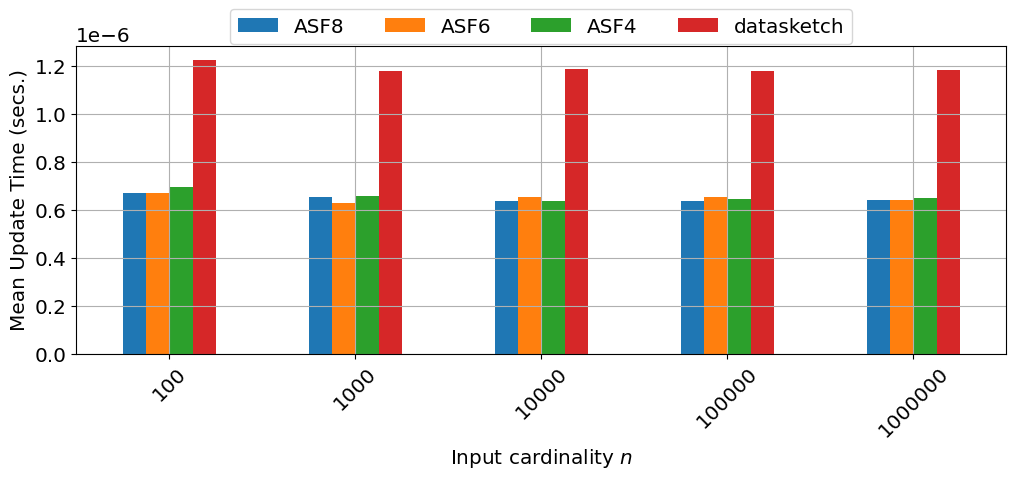

In [9]:
fig, ax = plt.subplots(figsize=(12,4))
df.plot(kind="bar", ax=ax)
ax.set_xlabel(r"Input cardinality $n$")
ax.set_ylabel("Mean Update Time (secs.)")
ax.grid()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),ncol=4, fancybox=True)
plt.xticks(rotation=45)
bar_tick_labels = [label.get_text() for label in plt.gca().get_xticklabels()]

We evaluate the factor speedup per update.  This is defined as the ratio of the total time per update required in using the datasketch library compred to the ASF implementation.  We see that the datasketch library takes almost twice as much time per update compared to the ASF implementations.

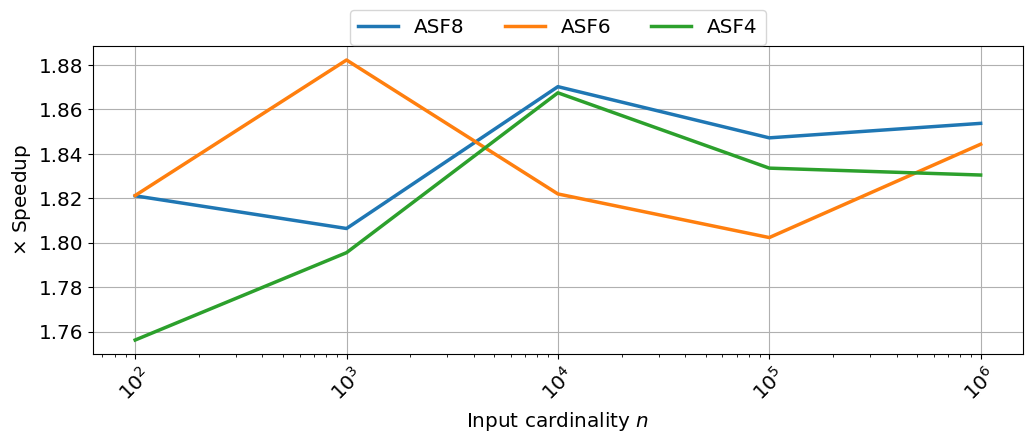

In [10]:
fig, ax = plt.subplots(figsize=(12,4)) 

methods = ["ASF8", "ASF6", "ASF4"]

xn = df.index 
for i, (method, colour) in enumerate(zip(methods, [asf8_color, asf6_color, asf4_color])):
    ax.plot(xn,  df["datasketch"] / df[method],
           color=colour, label=method) 

ax.set_xticks(xn) 
ax.set_xticklabels(bar_tick_labels) 
ax.set_xscale("log", base=10) 
ax.set_xlabel(r"Input cardinality $n$") 
ax.set_ylabel(r"$\times$ Speedup") 
ax.grid() 
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),ncol=4, fancybox=True)
plt.xticks(rotation=45) ;  # suppresses text output